In [1]:
import pandas as pd
import re
from plotnine import *

def isNaN(num):
    return num != num

### 1. Load datasets

In [2]:
# meta contains all book-level metadata information, such as publication year and primary language
meta = pd.read_csv("../processed_lc_2019/main_processed.csv", dtype={'literary': str})

/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/3485087148.py:2: DtypeWarning: Columns (8,10,11,18,22,23) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
# All different subject tables.
subject = pd.read_csv("../processed_lc_2019/subjects_table.csv")
subject_author = pd.read_csv("../processed_lc_2019/subjects_author_table.csv")
subject_corporate = pd.read_csv("../processed_lc_2019/subjects_corporate_table.csv")
subject_meeting = pd.read_csv("../processed_lc_2019/subjects_meeting_table.csv")
subject_title = pd.read_csv("../processed_lc_2019/subjects_title_table.csv")

/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/1908521583.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/1908521583.py:3: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/1908521583.py:4: DtypeWarning: Columns (2,11) have mixed types. Specify dtype option on import or set low_memory=False.
/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/1908521583.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
location_mapping = pd.read_csv("../country_code.csv")
languages = pd.read_csv("../processed_lc_2019/language_table.csv")

#### 1.1. Final sample

In [5]:
# meta1 is the final sample we use later.
sub6 = subject.loc[(subject['topic'] == "China") & (subject['general'] == "History")]
meta1 = meta.loc[meta.id.isin(sub6.id)]
# Remove all literary works
meta2 = meta1.loc[meta1['literary'] == "0"]

In [6]:
print(len(meta1.index))
print(len(meta2.index))

21904
20786


A total of 20,786 books were identified from this method.

#### 1.2 Processing subject information

In [7]:
sub1a = subject.loc[subject.id.isin(meta2.id)]
sub1a['chronological'] = sub1a['chronological'].astype(str)

# Unique subjects: 48.88k from all publications
print(len(sub1a.index))
print(len(sub1a.id.unique()))

48884
20786


/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/3252383805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
subject1b = subject_author.loc[subject_author.id.isin(meta2.id)]
subject1c = subject_corporate.loc[subject_corporate.id.isin(meta2.id)]
subject1d = subject_meeting.loc[subject_meeting.id.isin(meta2.id)]
subject1e = subject_title.loc[subject_title.id.isin(meta2.id)]

print(len(sub1a.index) + len(subject1b.index)+ len(subject1c.index)+ len(subject1d.index)+ len(subject1e.index))
print(48884 / 55025)

55025
0.8883961835529305


In [9]:
# clean dynasty information

def clean_chron(x):
    try:
        x = str(x)
    except:
        x = x
    x = re.sub('\.','',x)
    x = re.sub('  ',' ',x)
    x = x.lower()
    return(x)

sub1a['chron_cleaned'] = sub1a['chronological'].apply(clean_chron)
sub1a['geo_cleaned'] = sub1a['geographic'].apply(clean_chron)

/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/801625346.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/801625346.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
import re

def is_china(x):
    match = re.match("china|chinese", x)
    if match:
        return(True)
    else:
        return(False)

sub1a['geo_is_china'] = sub1a['geo_cleaned'].map(is_china)

/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/721614938.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# sub1b would be the narrow terms, while sub1c is the counter group
sub1b = sub1a.loc[(sub1a['geo_is_china'] == True) | (sub1a.topic == "China")]
sub1c = sub1a.loc[~ ((sub1a['geo_is_china'] == False) | (sub1a.topic == "China"))]

In [12]:
meta2b = meta2.merge(location_mapping[['code', 'mapped_country', 'mapped_country1']], how = "left", left_on = "place", right_on = "code")

def language_map(x):
    if x == "chi":
        return("Chinese")
    elif x == "eng":
        return("English")
    else:
        return("Others")

meta2b['language_mapped'] = meta2b['language'].map(language_map)

#### 1.3 Processing dynasty information

In [13]:
# Create dynasty mapping table

sub2 = pd.read_csv("../Parsed_Time_Periods_Manual_Annotated.csv")

sub2_dyn = sub2.assign(Items=sub2['dynasty_grouped'].str.split(', ')).explode('Items')
sub2_dyn1 = sub2_dyn.groupby("chron_cleaned").size().reset_index()

# create weight for the dynasty on each dynasty name
sub2_dyn1.columns = ['chron_cleaned', 'total_count']
sub2_dyn = sub2_dyn.merge(sub2_dyn1, on = "chron_cleaned", how = "left")
sub2_dyn['dynasty_weight'] = 1 / sub2_dyn['total_count']

sub2_dyn = sub2_dyn[['chron_cleaned', 'Items', 'dynasty_weight']]

In [14]:
# Create long period mapping table

sub2_long = sub2.assign(Items=sub2['long_term_grouped'].str.split(', ')).explode('Items')
sub2_long1 = sub2_long.groupby("chron_cleaned").size().reset_index()
sub2_long1.columns = ['chron_cleaned', 'total_count']
sub2_long = sub2_long.merge(sub2_long1, on = "chron_cleaned", how = "left")

sub2_long['dynasty_weight'] = 1 / sub2_long['total_count']

In [15]:
meta3 = meta2b.merge(sub1b, on = "id", how = "left")
meta3 = meta3.merge(sub2_dyn, on = "chron_cleaned", how = "left")
meta3 = meta3.merge(sub2_long, on = "chron_cleaned", how = "left")

In [16]:
meta3a = meta3.loc[isNaN(meta3.Items_x) == False]
print("How many books have any dynasty information?")
print(meta3a.id.nunique())

How many books have any dynasty information?
19441


### 2. Results

#### 2.1 Figure 1: Total book by year

In [17]:
meta2_f1 = meta2.loc[meta2.year_processed > 1945]
print(len(meta2_f1.index))
meta2_f2 = meta2b.loc[(meta2b.year_processed > 1945) & (meta2b.mapped_country.isin(['China', "US", "Taiwan", "Europe"]))]
print(len(meta2_f2.index))

19819
18564


In [18]:
fig_1 = (
    ggplot(meta2, aes(x = "year_processed")) + 
    geom_histogram(bins = 75) +
    xlim(1946, 2020) +
    labs(x = "Publication Year", y = "# Books") +
    theme_linedraw()
)
ggsave(fig_1, "../fig_1.jpg", width = 5, height = 3.6, dpi = 500)

/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 3.6 in image.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../fig_1.jpg
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 967 rows containing non-finite values.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/binning.py:152: FutureWarning: The provided callable <function sum at 0x7f7c8877c5e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 967 rows containing non-finite values.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/binning.py:152: FutureWarning: The provided callable <function sum at 0x7f7c8877c5e0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


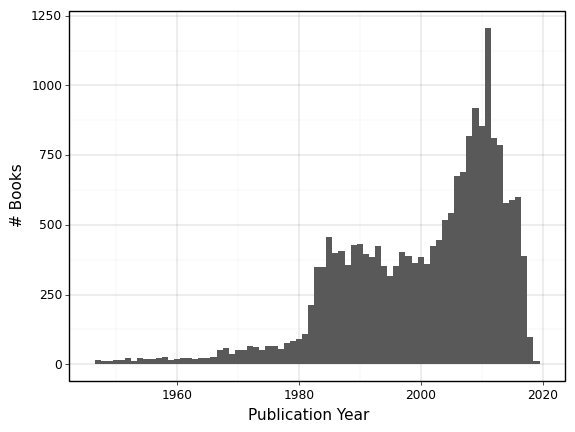

<ggplot: (8760854846115)>

In [19]:
fig_1

#### 2.2 Table 1: Region summary

In [46]:
region_summary = meta2b.loc[meta2b.year_processed > 1945].mapped_country1.value_counts().reset_index()
region_summary = region_summary.loc[region_summary['count'] > 1000]
region_summary['total'] = 20786
region_summary['share'] = region_summary['count'] / region_summary['total']
region_summary.to_csv("../table_1_region_summary.csv")

In [47]:
region_summary.head()

,mapped_country1,count,total,share
0,Greater-China,15624,20786,0.751660
1,US,1750,20786,0.084191
2,Europe,1190,20786,0.057250


#### 2.3 Table 2

In [48]:
region_summary = meta2b.loc[(meta2b.mapped_country.isin(['China', "US", "Taiwan", "Europe"])) & (meta2b.year_processed > 1945)].groupby(['mapped_country1', 'language_mapped']).size().reset_index()
region_summary.columns = ['region', 'language', 'count']
region_summary.head()

,region,language,count
0,Europe,Chinese,1
1,Europe,English,516
2,Europe,Others,673
3,Greater-China,Chinese,15380
4,Greater-China,English,194


In [49]:
for i in range(len(region_summary.index)):
    region = region_summary.loc[i, 'region']
    region_summary.loc[i, 'total'] = sum(region_summary.loc[region_summary.region == region, 'count'])

region_summary['share'] = region_summary['count'] / region_summary['total']

In [50]:
region_summary.to_csv("../table_2_region_language_summary.csv")

#### 2.2 Figure 2: Chinese / All by region

In [51]:
metab = meta.merge(location_mapping[['code', 'mapped_country', 'mapped_country1']], how = "left", left_on = "place", right_on = "code")

In [52]:
count_sum_compare1 = pd.DataFrame()

for i in range(1946, 2020):
    sub1 = meta2.loc[meta2.year_processed == i]
    sub2 = meta.loc[meta.year_processed == i]
    count_sum_compare1 = pd.concat([
        count_sum_compare1,
        pd.DataFrame(
            {"year":i,
            "count_catalog":len(sub2.index),
            "count_history":len(sub1.index),}, index = [0]
        )
    ])
    
count_sum_compare1['ratio'] = count_sum_compare1['count_history'] / count_sum_compare1['count_catalog']

In [71]:
count_sum_compare2 = pd.DataFrame()

for location in ["US", "Greater-China", "Europe"]:
    metab1 = metab.loc[metab['mapped_country1'] == location]
    meta2b1 =meta2b.loc[meta2b['mapped_country1'] == location]

    for i in range(1946, 2020):
        sub1 = metab1.loc[metab1.year_processed == i]
        sub2 = meta2b1.loc[meta2b1.year_processed == i]
        count_sum_compare2 = pd.concat([
            count_sum_compare2,
            pd.DataFrame(
                {"year":i,
                 "mapped_country1":location,
                "count_catalog_us":len(sub1.index),
                "count_history_us":len(sub2.index),}, index = [0]
                )
    ])
    
count_sum_compare2['ratio'] = count_sum_compare2['count_history_us'] / count_sum_compare2['count_catalog_us']

In [72]:
count_sum_compare1['mapped_country1'] = "All Countries"

count_sum_compare1 = count_sum_compare1[['year', 'mapped_country1', 'ratio']]
count_sum_compare2 = count_sum_compare2[['year', 'mapped_country1', 'ratio']]

count_sum_compare2a = pd.concat([count_sum_compare1, count_sum_compare2])

In [73]:
count_sum_compare3 = pd.DataFrame()

for location in ["All Countries", "US", "Greater-China", "Europe"]:
    sub = count_sum_compare2a.loc[count_sum_compare2a.mapped_country1 == location]
    sub["mean_ratio"] = sub["ratio"].rolling(window=3, center=True).mean()
    count_sum_compare3 = pd.concat([count_sum_compare3, sub])

count_sum_compare3.head()

/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/651547873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/651547873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/651547873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,year,mapped_country1,ratio,mean_ratio
0,1946,All Countries,0.000567,NaN
0,1947,All Countries,0.000602,0.000571
0,1948,All Countries,0.000545,0.000515
0,1949,All Countries,0.000399,0.000495
0,1950,All Countries,0.000542,0.000523


In [74]:
count_sum_compare3['mapped_country1'] = count_sum_compare3['mapped_country1'].replace('Greater-China', 'Greater China')
count_sum_compare3['mapped_country1'] = count_sum_compare3['mapped_country1'].replace('US', 'U.S.')
count_sum_compare3['mapped_country1'] = pd.Categorical(count_sum_compare3['mapped_country1'], 
                                                       categories=['All Countries', 'U.S.', 'Greater China', 'Europe'])


f_2 = (
    ggplot(count_sum_compare3.loc[count_sum_compare3.year < 2018], aes(x = "year")) +
    geom_line(aes(y = "mean_ratio")) +
    labs(x = "Publication Year", y = "# Chinese History Books \n / # All Books") +
    facet_wrap(" ~ mapped_country1", scales = "free_y", nrow = 2)  +
    theme_linedraw() +
    theme(panel_spacing_x = 0.7)
)

ggsave(f_2, "../f_2.jpg", width = 5.5, height = 4, dpi = 500)

/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5.5 x 4 in image.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../f_2.jpg
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/likai/opt/anaconda3/lib/python3.9/site-pa

/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/geoms/geom.py:231: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future d

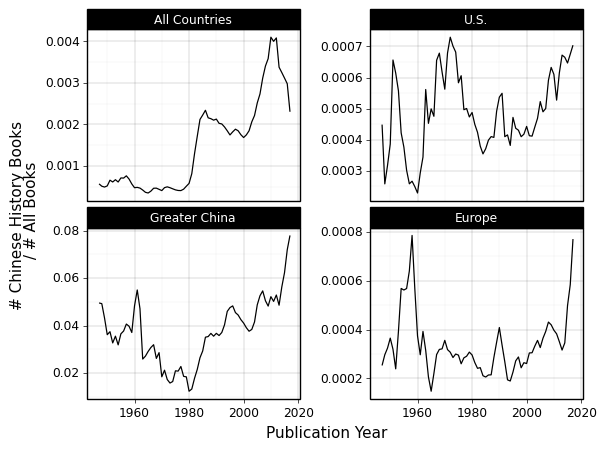

<ggplot: (8760860056601)>

In [75]:
f_2

#### 2.3 Figure 3: Total books by region

In [76]:
meta2b1.mapped_country1.value_counts()

mapped_country1
Europe    1347
Name: count, dtype: int64

In [77]:
meta2b1 = meta2b.loc[(meta2b.year_processed > 1945) & (meta2b.year_processed < 2019)]

meta2b_us = meta2b1.loc[meta2b1.mapped_country1 == "US"]
meta2b_china = meta2b1.loc[meta2b1.mapped_country1 == "Greater-China"]
meta2b_eu = meta2b1.loc[meta2b1.mapped_country1 == "Europe"]

In [78]:
pub_sum_1 = meta2b1.groupby('year_processed').size().reset_index()
pub_sum_2 = meta2b_us.groupby('year_processed').size().reset_index()
pub_sum_3 = meta2b_china.groupby('year_processed').size().reset_index()
pub_sum_4 = meta2b_eu.groupby('year_processed').size().reset_index()

pub_sum_1.columns = ['year', 'total']
pub_sum_2.columns = ['year', 'count']
pub_sum_3.columns = ['year', 'count']
pub_sum_4.columns = ['year', 'count']

pub_sum_2['category'] = "US"
pub_sum_3['category'] = "Greater-China"
pub_sum_4['category'] = "EU"

pub_sum_final = pd.concat([pub_sum_2, pub_sum_3, pub_sum_4])

In [79]:
pub_sum_final.category.value_counts()

category
Greater-China    73
EU               73
US               72
Name: count, dtype: int64

In [80]:
pub_sum_final1 = pd.DataFrame()

for location in ["US", "Greater-China", "EU"]:
    sub = pub_sum_final.loc[pub_sum_final.category == location]
    sub["count_new"] = sub["count"].rolling(window=3, center=True).mean() 
    pub_sum_final1 = pd.concat([pub_sum_final1, sub])

pub_sum_final1.tail()

/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/1785417631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/1785417631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/f3/ps2lxzsn0xd88g38v89kxplc0000gn/T/ipykernel_5383/1785417631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,year,count,category,count_new
68,2014,22,EU,23.666667
69,2015,27,EU,32.000000
70,2016,47,EU,34.000000
71,2017,28,EU,32.333333
72,2018,22,EU,NaN


In [81]:
pub_sum_final1['category'] = pub_sum_final1['category'].replace('Greater-China', 'Greater China')
pub_sum_final1['category'] = pub_sum_final1['category'].replace('EU', 'Europe')
pub_sum_final1['category'] = pub_sum_final1['category'].replace('US', 'U.S.')
pub_sum_final1['category'] = pd.Categorical(pub_sum_final1['category'], 
                                                   categories=['U.S.', 'Greater China', 'Europe'])


f_3 = (
    ggplot(pub_sum_final1.loc[(pub_sum_final1.year > 1946) & (pub_sum_final1.year < 2018)], 
           aes(x = "year", y = "count_new", group = "category", color = "category")) +
    geom_line() +
    scale_y_log10() +
    labs(x = "Publication Year", y = "Books (Three-Year Mean Value)") +
    scale_color_discrete(name = "Region") +
    theme_linedraw()
)
ggsave(f_3, "../f_3.jpg", width = 5.5, height = 4, dpi = 500)

/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5.5 x 4 in image.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../f_3.jpg


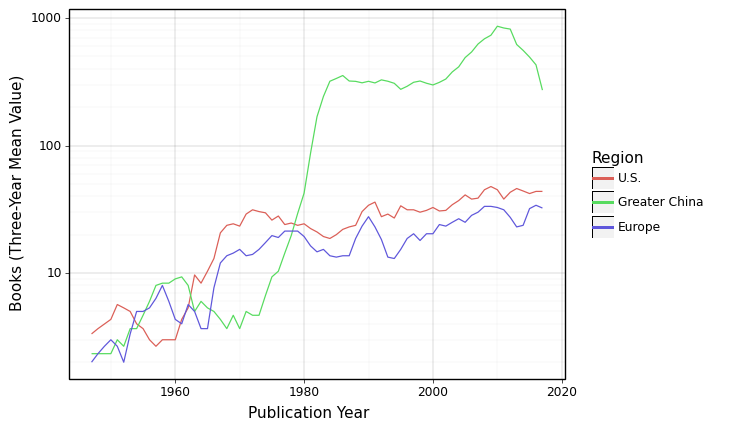

<ggplot: (8759954628045)>

In [82]:
f_3

#### 2.4 Table 3

In [100]:
meta3a.head()

,Unnamed: 0.1,Unnamed: 0,id,leader_6,leader_7,leader_17,leader_18,edit_date,file_date,pub_code,...,begin_year_manual,end_year_manual,dynasty_grouped,dynasty_grouped_multiple,long_term_grouped,long_term_grouped_multiple,note,Items_y,total_count,dynasty_weight_y
0,1440,1440,a84175412,a,m,,a,20070827,850510,s,...,1861,1912,Qing,NaN,Ming-Qing,NaN,NaN,Ming-Qing,1.0,1.0
1,1823,1823,a84175934,a,m,,a,20010317,840620,s,...,1911,1912,Qing,NaN,Ming-Qing,NaN,NaN,Ming-Qing,1.0,1.0
4,2168,2168,a84176357,a,m,,a,20070825,841129,s,...,1976,2002,People's Republic,NaN,Twentieth Century,NaN,The 21st century is included,Twentieth Century,1.0,1.0
6,4285,4285,a84178814,a,m,,a,20130412,840627,s,...,1949,indefinite,People's Republic,NaN,Twentieth Century,NaN,The 21st century is included,Twentieth Century,1.0,1.0
7,4582,4582,a84179135,a,m,,a,20080619,880106,s,...,1913,1913,Republic,NaN,Twentieth Century,NaN,NaN,Twentieth Century,1.0,1.0


In [103]:
dyn_sum1 = meta3a.groupby("Items_x").size().reset_index()
dyn_sum1.columns = ['Dynasty', 'Total_count']

dyn_sum2 = meta3a.groupby("Items_x")['dynasty_weight_x'].sum().reset_index()
dyn_sum2.columns = ['Dynasty', 'dynasty_weight']

dyn_sum = dyn_sum1.merge(dyn_sum2, on = "Dynasty", how = "left").sort_values(by='Total_count', ascending=False)
dyn_sum.head()

,Dynasty,Total_count,dynasty_weight
8,Qing,9093,7140.380952
9,Republic,8091,6183.666667
5,People's Republic,6806,4902.166667
10,Song,3105,1747.581502
3,Ming,3050,1670.581502


In [104]:
dyn_sum['specialization_index'] = dyn_sum['dynasty_weight'] / dyn_sum['Total_count']

In [106]:
dyn_sum.to_csv("../repo/Appendix_Table_2_dynasty_specialization.csv")

#### 2.5 Figure 4: 

In [87]:
meta3c = meta3a.loc[meta3a.mapped_country1.isin(['Greater-China', 'Europe', "US"]) & (meta3a.year_processed > 1945)]

print(len(meta3c.index))
print(len(meta3a.index))

dyn_sum2 = meta3c.groupby(['mapped_country1', "Items_x"])['dynasty_weight_x'].sum().reset_index()
dyn_sum2.columns = ['mapped_country1', 'Items', 'dynasty_weight']

dyn_sum2a = meta3c.groupby(["mapped_country1", "Items_x"]).size().reset_index()
dyn_sum2a.columns = ['mapped_country1', 'Items', 'Total_count']

dyn_sum2b = dyn_sum2a.merge(dyn_sum2, on = ["mapped_country1", "Items"], how = "left").sort_values(by='Total_count', ascending=False)
dyn_sum2b['index'] = dyn_sum2b['dynasty_weight'] / dyn_sum2b['Total_count']

dyn_sum2b.head()

49897
57098


,mapped_country1,Items,Total_count,dynasty_weight,index
24,Greater-China,Qing,6814,5431.904762,0.797168
25,Greater-China,Republic,5945,4601.833333,0.774068
21,Greater-China,People's Republic,4388,3046.333333,0.694242
26,Greater-China,Song,2027,1359.485348,0.670688
19,Greater-China,Ming,1920,1243.485348,0.647649


In [91]:
dyn_sum2b.Items.value_counts()

Items
Qing                               3
Republic                           3
People's Republic                  3
Song                               3
Ming                               3
Tang                               3
Han                                3
Zhou                               3
Qin                                3
Three Kingdoms                     3
Northern and Southern Dynasties    3
Jin                                3
Sui                                3
Pre-Zhou                           3
Five Dynasties                     3
Yuan                               3
Name: count, dtype: int64

In [94]:
dyn_sum2c = dyn_sum2b

# Define the desired order for the x-axis categories
custom_order = ['Pre-Zhou', 'Zhou', "Qin", 'Han', "Three Kingdoms", "Jin", "Northern and Southern Dynasties", "Sui", 'Tang', 
                'Five Dynasties', 'Song', "Yuan", 'Ming', 'Qing', 'Republic', "People's Republic"]

# Convert the 'category' column to a Categorical type with the custom order
dyn_sum2c['Items'] = pd.Categorical(dyn_sum2c['Items'], categories=reversed(custom_order), ordered=True)

dyn_sum2c['mapped_country1'] = dyn_sum2c['mapped_country1'].replace('Greater-China', 'Greater China')
dyn_sum2c['mapped_country1'] = dyn_sum2c['mapped_country1'].replace('US', 'U.S.')
dyn_sum2c['mapped_country1'] = pd.Categorical(dyn_sum2c['mapped_country1'], 
                                                   categories=['Europe', 'Greater China', 'U.S.'])

dyn_sum2c.to_csv("../fig4_data.csv")

# Define the desired order (same as legend)
region_order = ["U.S.", "Greater China", "Europe" ]

fig4 = (
    ggplot(dyn_sum2c, aes(x = "Items", y = "index", fill = "mapped_country1")) +
    geom_bar(stat = "identity", position = 'dodge') +
    labs(x = "Dynasty", y = "Dedication Index") + 
    scale_fill_manual(name = "Region",
                      values = ["#1B9E77FF", "#D95F02FF", "#7570B3FF"],
                      breaks=region_order) +
    theme_linedraw() +
    coord_flip()
)
ggsave(fig4, "../fig_4_region_dynasty.jpg", width = 5, height = 6, dpi = 500)

/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 6 in image.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../fig_4_region_dynasty.jpg


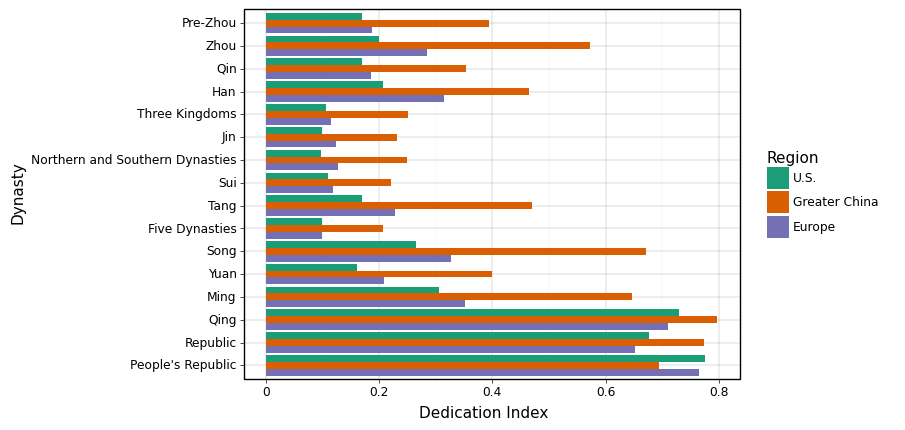

<ggplot: (8759957753299)>

In [95]:
fig4

#### 2.6 Figure 5: 

In [56]:
meta3a.head()

,Unnamed: 0.1,Unnamed: 0,id,leader_6,leader_7,leader_17,leader_18,edit_date,file_date,pub_code,...,begin_year_manual,end_year_manual,dynasty_grouped,dynasty_grouped_multiple,long_term_grouped,long_term_grouped_multiple,note,Items_y,total_count,dynasty_weight_y
0,1440,1440,a84175412,a,m,,a,20070827,850510,s,...,1861,1912,Qing,NaN,Ming-Qing,NaN,NaN,Ming-Qing,1.0,1.0
1,1823,1823,a84175934,a,m,,a,20010317,840620,s,...,1911,1912,Qing,NaN,Ming-Qing,NaN,NaN,Ming-Qing,1.0,1.0
4,2168,2168,a84176357,a,m,,a,20070825,841129,s,...,1976,2002,People's Republic,NaN,Twentieth Century,NaN,The 21st century is included,Twentieth Century,1.0,1.0
6,4285,4285,a84178814,a,m,,a,20130412,840627,s,...,1949,indefinite,People's Republic,NaN,Twentieth Century,NaN,The 21st century is included,Twentieth Century,1.0,1.0
7,4582,4582,a84179135,a,m,,a,20080619,880106,s,...,1913,1913,Republic,NaN,Twentieth Century,NaN,NaN,Twentieth Century,1.0,1.0


In [57]:
dynasty_sum = meta3a.groupby("year_processed")['dynasty_weight_y'].sum().reset_index()
dynasty_sum.columns = ['year_processed', 'total']

dynastry_year_sum = meta3a.groupby(['year_processed', 'Items_y'])['dynasty_weight_y'].sum().reset_index()
dynastry_year_sum.columns = ['year_processed', 'period', 'count']

dynastry_year_sum = dynastry_year_sum.merge(dynasty_sum, on = "year_processed", how = "left")
dynastry_year_sum = dynastry_year_sum.loc[(dynastry_year_sum.year_processed > 1945) & (dynastry_year_sum.year_processed < 2019)]
dynastry_year_sum['share'] = dynastry_year_sum['count'] / dynastry_year_sum['total']

In [58]:
dynastry_year_sum

,year_processed,period,count,total,share
316,1946,Ming-Qing,1.000000,11.0,0.090909
317,1946,Twentieth Century,10.000000,11.0,0.909091
318,1947,Ming-Qing,1.000000,17.0,0.058824
319,1947,Twentieth Century,16.000000,17.0,0.941176
320,1948,Tang-Song-Yuan,1.000000,14.0,0.071429
...,...,...,...,...,...
590,2017,Twentieth Century,411.000000,1287.0,0.319347
591,2018,Ming-Qing,65.666667,326.0,0.201431
592,2018,Pre-Tang,83.666667,326.0,0.256646
593,2018,Tang-Song-Yuan,47.666667,326.0,0.146217


In [59]:
# Maybe include this graph to show the stable pattern over time.

fig_5 = (
    ggplot(dynastry_year_sum, aes(x = "year_processed", y = "share")) + 
    geom_line(aes(color = "period", group = "period")) +
    labs(x = "Publication Year", y = "Share of collection") +
    scale_color_discrete(name = "Long Period") +
    scale_y_continuous(
        limits = [0, 1],
        breaks = [0, 0.25, 0.5, 0.75, 1],
        labels = ["0", "25%", "50%", "75%", "100%"]
    ) +
    theme_linedraw()
)
ggsave(fig_5, "../fig_5.jpg", width = 5, height = 3.6, dpi = 500)

/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 3.6 in image.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../fig_5.jpg


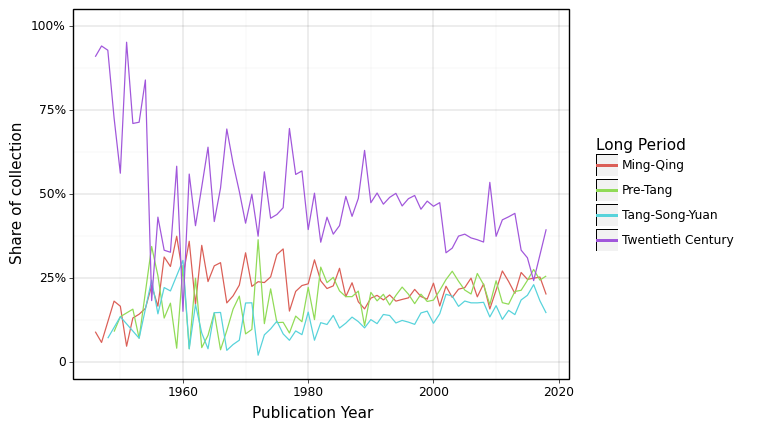

<ggplot: (8789840092368)>

In [60]:
fig_5

#### 2.7 Figure 6

In [61]:
dynasty_sum1 = meta3a.groupby(["year_processed", "mapped_country1"])['dynasty_weight_y'].sum().reset_index()
dynasty_sum1.columns = ['year_processed', 'mapped_country1', 'total']

dynastry_year_sum1 = meta3a.groupby(['year_processed', 'Items_y', "mapped_country1"])['dynasty_weight_y'].sum().reset_index()
dynastry_year_sum1.columns = ['year_processed', 'Items', "mapped_country1", 'count']

dynastry_year_sum2 = dynastry_year_sum1.merge(dynasty_sum1, on = ["year_processed", 'mapped_country1'], how = "left")
dynastry_year_sum2 = dynastry_year_sum2.loc[(dynastry_year_sum1.year_processed > 1959) & (dynastry_year_sum1.year_processed < 2019)]
dynastry_year_sum2['share'] = dynastry_year_sum2['count'] / dynastry_year_sum2['total']

In [76]:
cat_order = ['Pre-Tang', "Tang-Song-Yuan", "Ming-Qing", "Twentieth Century"]
dynastry_year_sum2['Items_new'] = pd.Categorical(dynastry_year_sum2['Items'], categories=cat_order, ordered=True)

dynastry_year_sum2['mapped_country1'] = dynastry_year_sum2['mapped_country1'].replace('Greater-China', 'Greater China')
dynastry_year_sum2['mapped_country1'] = dynastry_year_sum2['mapped_country1'].replace('US', 'U.S.')
dynastry_year_sum2['mapped_country1'] = pd.Categorical(dynastry_year_sum2['mapped_country1'], 
                                                   categories=['U.S.', 'Greater China', 'Europe'])

f6 = (
    ggplot(dynastry_year_sum2.loc[dynastry_year_sum2.mapped_country1.isin(['Greater China', "U.S.", "Europe"])],
          aes(x = "year_processed", y = "share")) +
    geom_bar(aes(group = "Items_new", fill = "Items_new"), stat = "identity", width = 0.85) +
    facet_wrap(" ~ mapped_country1", nrow = 3) +
    scale_fill_brewer(name = "Long Period", type="qual", palette="Set1") +
    xlim(1978, 2019) +
    labs(x = "Publication Year", y = "Share") +
    scale_y_continuous(
        breaks = [0, 0.25, 0.5, 0.75, 1],
        labels = ["0", "25%", "50%", "75%", "100%"]
    ) +
    theme_linedraw()
)

ggsave(f6, "../fig_6.jpg", height = 5, width = 5, )

/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../fig_6.jpg
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:391: PlotnineWarning: position_stack : Removed 166 rows containing missing values.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and 

/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:391: PlotnineWarning: position_stack : Removed 166 rows containing missing values.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bar : Removed 12 rows containing missing values.
/Users/likai/opt/anaconda3/lib/python3.9/site-packages/plotnine/geo

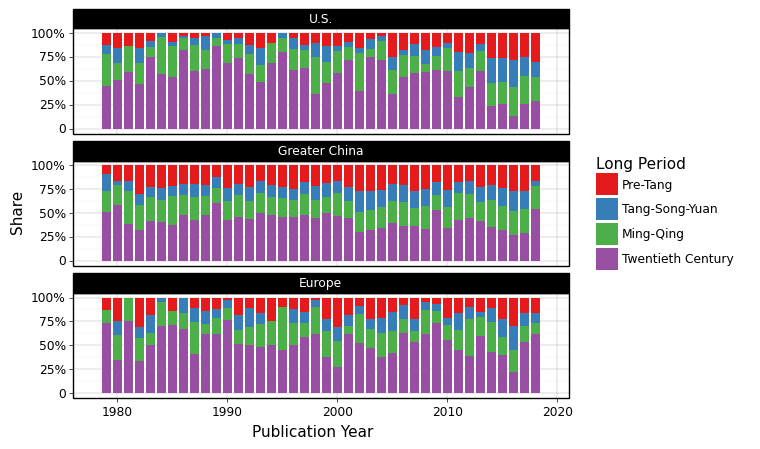

<ggplot: (8789838695030)>

In [77]:
f6